In [15]:
from traitlets.config.configurable import Configurable
from traitlets import HasTraits, Int, Float, Unicode, Bool, Any, Dict, List
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np

from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.calc import get_wind_components
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.io.gini import GiniFile
from metpy.plots.ctables import registry


class MetpyMap(HasTraits):

    file_location = Unicode(allow_none=False, help='location of the data file').tag(config=True)

    bbox = Dict(traits={"east": Float(allow_none=False), "west": Float(allow_none=False),
                        "north": Float(allow_none=False), "south": Float(allow_none=False)},
                help='map bounding box').tag(config=True) 
    
    avail_features = {
                      'OCEANS': cartopy.feature.OCEAN,
                      'LAKES': cartopy.feature.LAKES, 
                      'RIVERS': cartopy.feature.RIVERS,
                      'LAND': cartopy.feature.LAND,
                      'COASTLINE': cartopy.feature.COASTLINE,
                      'BORDERS': cartopy.feature.BORDERS, 
                      'STATES': cartopy.feature.NaturalEarthFeature(
                                    category='cultural',
                                    name='admin_1_states_provinces_lakes',
                                    scale='50m',
                                    facecolor='none')
                     }
    
    features = Dict(default_value={f : False for f in avail_features.keys()}, 
                    traits={f : Bool() for f in avail_features.keys()},
                    help='Toggle features to draw').tag(config=True)

    projection_options = Dict(traits={"from_proj": Any(allow_none=False), 
                                      "to_proj": Any(allow_none=False)},
                              help='projection options').tag(config=True)
    
    def draw_map(self, view):

        view.set_extent([self.bbox['west'], self.bbox['east'], 
                         self.bbox['south'], self.bbox['north']])

        for key, activated in self.features.items():
            if activated and key in self.avail_features:
                print(self.avail_features[key])
                view.add_feature(self.avail_features[key])
            
        return view


class StationMap(MetpyMap):
    
    def __init__(self, file, bbox, **kwargs):
        
        self.file_location = file
        
        self.bbox = bbox
        
        usr_features = kwargs['features'].keys()
        for feature in self.features.keys():
            if feature in usr_features:
                self.features[feature] = kwargs['features'][feature] 
        
        self.projection_options = kwargs['proj_options']
        
        self.data = self.load_text()
        
                
    def load_text(self):

        f = get_test_data(self.file_location)

        all_data = np.loadtxt(f, skiprows=1, delimiter=',',
                              usecols=(1, 2, 3, 4, 5, 6, 7, 17, 18, 19),
                              dtype=np.dtype([('stid', '3S'), ('lat', 'f'), ('lon', 'f'),
                                              ('slp', 'f'), ('air_temperature', 'f'),
                                              ('cloud_fraction', 'f'), ('dewpoint', 'f'),
                                              ('weather', '16S'),
                                              ('wind_dir', 'f'), ('wind_speed', 'f')]))

        all_stids = [s.decode('ascii') for s in all_data['stid']]

        whitelist = ['OKC', 'ICT', 'GLD', 'MEM', 'BOS', 'MIA', 'MOB', 'ABQ', 'PHX', 'TTF',
                     'ORD', 'BIL', 'BIS', 'CPR', 'LAX', 'ATL', 'MSP', 'SLC', 'DFW', 'NYC', 'PHL',
                     'PIT', 'IND', 'OLY', 'SYR', 'LEX', 'CHS', 'TLH', 'HOU', 'GJT', 'LBB', 'LSV',
                     'GRB', 'CLT', 'LNK', 'DSM', 'BOI', 'FSD', 'RAP', 'RIC', 'JAN', 'HSV', 'CRW',
                     'SAT', 'BUY', '0CO', 'ZPC', 'VIH']

        # Loop over all the whitelisted sites, grab the first data, and concatenate them
        return np.concatenate([all_data[all_stids.index(site)].reshape(1, ) for site in whitelist])
    
    
    def draw_map(self, view):

        from_proj = self.projection_options['from_proj']

        view = MetpyMap.draw_map(self, view)

        x = self.data['lon']
        y = self.data['lat']

        u, v = get_wind_components((self.data['wind_speed'] * units('m/s')).to('knots'),
                                    self.data['wind_dir'] * units.degree)

        stationplot = StationPlot(view, x, y, transform=from_proj,
                                  fontsize=12)

        stationplot.plot_parameter('NW', self.data['air_temperature'], color='red')
        stationplot.plot_parameter('SW', self.data['dewpoint'], color='darkgreen')

        stationplot.plot_parameter('NE', self.data['slp'],
                                   formatter=lambda sp: format(10 * sp, '.0f')[-3:])

        stationplot.plot_barb(u, v)

        return view

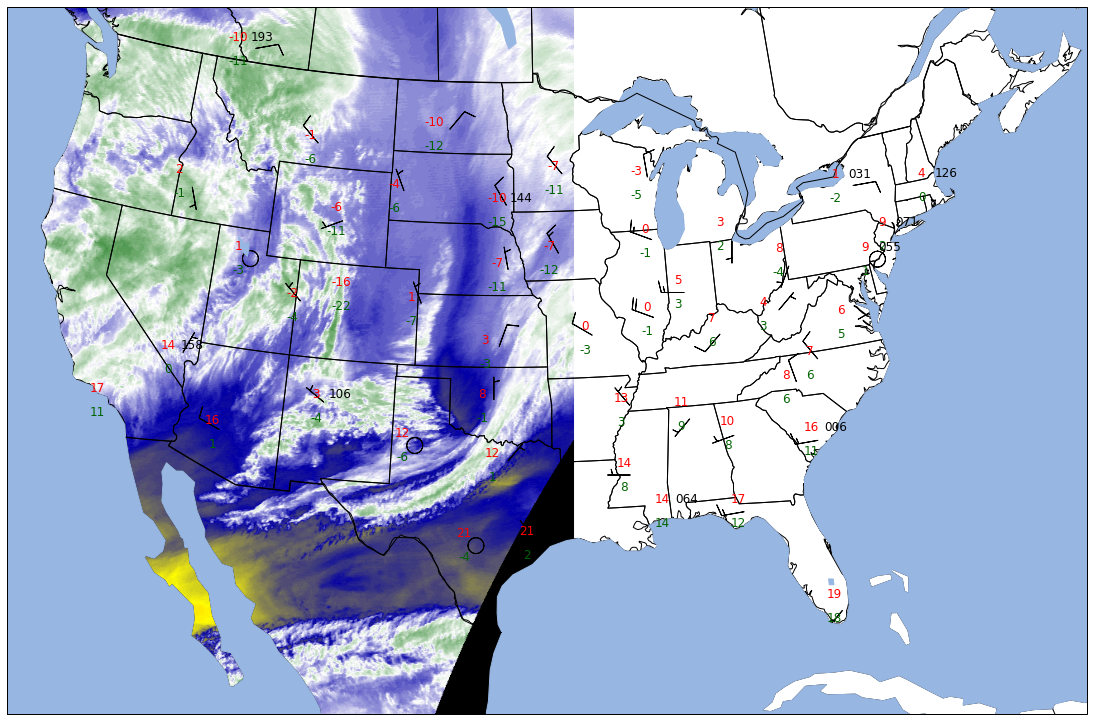

In [24]:
from ipywidgets import interact
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

f = GiniFile(get_test_data('WEST-CONUS_4km_WV_20151208_2200.gini'))

ds = f.to_dataset()
x = ds.variables['x'][:]
y = ds.variables['y'][:]
dat = ds.variables['WV']
proj_var = ds.variables[dat.grid_mapping]

globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.earth_radius,
                   semiminor_axis=proj_var.earth_radius)
proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                             central_latitude=proj_var.latitude_of_projection_origin,
                             standard_parallels=[proj_var.standard_parallel],
                             globe=globe)


wv_norm, wv_cmap = registry.get_with_steps('WVCIMSS', 0, 1)

long_range = (-120, -60, 5)
lat_range = (20, 50, 5)


@interact(east=long_range, west=long_range, north=lat_range, south=lat_range,
             coastline=True, lakes=True, states=True, borders=True, oceans=True,
             wvoverlay=False)
def set_map(coastline=True, lakes=True, states=True, borders=True, oceans=True,
            east=-70, west=-120, south=20, north=50,
            wvoverlay=False):
    
    sp = StationMap("station_data.txt", 
                {"east": east, "west": west, "north": north, "south": south},
                features={"COASTLINE": coastline, "LAKES": lakes, "STATES": states,
                          "BORDERS": borders, "OCEANS": oceans},
                proj_options={"to_proj": to_proj, "from_proj": from_proj})

        
    view = plt.axes([0, 0, 1, 1], projection=to_proj)
    
    if wvoverlay:
   
        xmn, ymn = to_proj.transform_point(x.min(), y.min(), proj)
        xmx, ymx = to_proj.transform_point(x.max(), y.max(), proj)
        view.imshow(dat[:], cmap=wv_cmap, norm=wv_norm, zorder=0,
               extent=(xmn, xmx, ymn, ymx), origin='upper')

    sp.draw_map(view)
    

        